In [1]:
import utils.data_preprocess as data_preprocess
import utils.tokenize_data_helper as tokenize_data_helper
import nengo
from nengo.exceptions import SpaParseError, ValidationError
import sys
import numpy as np
from nengo.spa import pointer
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


/home/yyliu/anaconda3/envs/NLP/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DIM = 100
W2V_MODEL = '100features_20context_20mincount_zht'
CONTROL_TRAIN = 'control.txt'
DEMENTIA_TRAIN = 'dementia.txt'
CONTROL_ORIGIN = 'control_origin.txt'
DEMENTIA_ORIGIN = 'dementia_origin.txt'
CONTROL_TEST = 'control_test.txt'
DEMENTIA_TEST = 'dementia_test.txt'

In [3]:
w2v_model, _, w2v_dict = data_preprocess.load_wordvec_model(W2V_MODEL)
vocab = nengo.spa.Vocabulary(DIM, max_similarity=0.3) # optional max_similarity: 0.1

Load word2vec model sucess ...
Number of token: 259425
Dimensions of word vector: 100


In [4]:
num_words = 1000
x_train, y_train = data_preprocess.read_sentence(DEMENTIA_TRAIN, CONTROL_TRAIN)
x_train_seg = data_preprocess.segmentation(x_train)
x_test, y_test = data_preprocess.read_sentence(DEMENTIA_TEST, CONTROL_TEST)
x_test_seg = data_preprocess.segmentation(x_test)
data_helper = tokenize_data_helper.tokenize_data_helper(x_train_seg, num_words)
x_train_tokens, x_test_tokens = data_helper.tokenize_data(x_train_seg, x_test_seg)
x_train_pad, x_test_pad = data_helper.pad_tokenize(x_train_tokens, x_test_tokens)


Building prefix dict from /home/yyliu/code/NLP/data/dict.txt.big ...


total number of train set: 784
sentence number of dementia subject: 394
sentence number of control normal subject: 390


Dumping model to file cache /tmp/jieba.u74f96b08eeb68fe4b0ac4c13a6f276ed.cache
Loading model cost 1.520 seconds.
Prefix dict has been built succesfully.


total number of train set: 89
sentence number of dementia subject: 48
sentence number of control normal subject: 41


In [ ]:
x_train_tokens[0]

In [ ]:
# test_text = []
# for i in x_train_tokens[0]:
#     test_text.append(data_helper.tokens_to_string(i))
# print(test_text)
data_helper.tokens_to_string(x_train_tokens[0])

In [ ]:
oov = []
# for sentences in x_train_seg:
#     for token in sentences.split():
#         try:
#             vocab.add(str('V'+token), w2v_dict[token])
#         except KeyError:
#             oov.append(token)
#             value = vocab.create_pointer(attempts=100)
#             vocab.add(str('V'+token), value)
#             continue
#         except ValidationError:
#             pass
# data_helper.tokenizer.word_index
for token, i in data_helper.tokenizer.word_index.items():
    try:
        vocab.add(str('V'+token), w2v_dict[token])
    except KeyError:
        oov.append(token)
        value = vocab.create_pointer(attempts=100)
        vocab.add(str('V'+token), value)
        continue
vocab.add('Start', np.zeros(DIM))

In [ ]:
print(len(oov))

In [ ]:
assert len(vocab.keys)-1 == len(data_helper.tokenizer.word_index.keys())
print(len(vocab.keys))
print(len(data_helper.tokenizer.word_index.keys()))

In [ ]:
# print(vocab.keys[0], vocab[vocab.keys[0]])
print(vocab.keys[-5:-1])

In [5]:
model_path = 'edu/stanford/nlp/models/lexparser/chinesePCFG.ser.gz'

In [6]:
s = u"媽媽 在 洗 盤子"

# 依存分析
from nltk.parse.stanford import StanfordDependencyParser
parser = StanfordDependencyParser(model_path=model_path)
result = list(parser.parse(s.split()))
for row in result[0].triples():
    print(row)

# 句法结构分析
from nltk.parse.stanford import StanfordParser
parser = StanfordParser(model_path=model_path)
result_2 = list(parser.parse(s.split()))
for r in result_2:
    print(r)
    print(r.draw())


(('洗', 'VV'), 'nsubj', ('媽媽', 'NR'))
(('洗', 'VV'), 'advmod', ('在', 'AD'))
(('洗', 'VV'), 'dobj', ('盤子', 'NN'))
(ROOT (IP (NP (NR 媽媽)) (VP (ADVP (AD 在)) (VP (VV 洗) (NP (NN 盤子))))))
None


In [ ]:
result = []
for s in x_train_seg:
    tree_tmp = list(parser.parse(s.split()))
    result.append(tree_tmp[0])

In [ ]:
# for r in result:
#     print(r.height())
result_height = [r.height() for r in result]
print(np.mean(result_height[:394]))
print(np.mean(result_height[394:]))
import matplotlib.pyplot as plt
import seaborn
seaborn.distplot(result_height[:394], color='r', label='dementia')
seaborn.distplot(result_height[394:], color='g', label='control')
plt.title('Distribution of syntactic complexity')
plt.legend()
plt.show()

In [7]:
x_train_sent, y_train_sent = data_preprocess.read_sentence(DEMENTIA_ORIGIN, CONTROL_ORIGIN)
print(x_train_sent[0])
x_train_sent_seg = data_preprocess.segmentation(x_train_sent)

total number of train set: 873
sentence number of dementia subject: 442
sentence number of control normal subject: 431
三個人


In [9]:
result_sent = []
for p in x_train_sent_seg:
    tree_sent = list(parser.parse(p.split()))
    result_sent.append(tree_sent[0])

6.891402714932127
7.642691415313225


/home/yyliu/anaconda3/envs/NLP/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


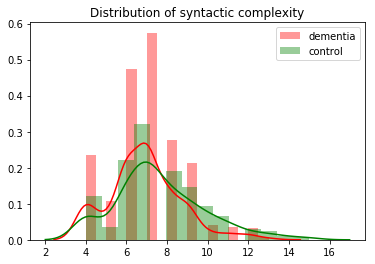

In [11]:
result_para_height = [r.height() for r in result_sent]
print(np.mean(result_para_height[:442]))
print(np.mean(result_para_height[442:]))
import matplotlib.pyplot as plt
import seaborn
seaborn.distplot(result_para_height[:442], color='r', label='dementia')
seaborn.distplot(result_para_height[442:], color='g', label='control')
plt.title('Distribution of syntactic complexity')
plt.legend()
plt.show()

In [17]:
with open('sentence_depth.csv', 'w') as f:
    for i in result_para_height:
        f.write(str(i))
        f.write('\n')

In [ ]:
for i, r in enumerate(result_2[0].subtrees()):
    print(r, i)
# result_2[0].subtrees()

In [ ]:
tree = result_2[0]
print(tree.pos())
print(tree.height)

In [ ]:
for s in tree.subtrees(lambda tree: tree.height() == 2):
    print(s.productions())

In [ ]:
# parser = StanfordParser(model_path=model_path)
# def parser_tree(sentence):
#     result = list(parser.parse(sentence.split()))
#     return result

In [ ]:
# x_train_tree = []
# for s in x_train_seg:
#     tree_tmp = list(parser.parse(s.split()))
#     x_train_tree.append(tree_tmp)

In [ ]:
import jieba.posseg as pseg

In [ ]:
x_train_postag = []
for s in x_train:
    x_train_postag.append(pseg.lcut(s))

In [ ]:
flag_dict = {}
for s in x_train_postag:
    for word, flag in s:
        if flag not in flag_dict:
            flag_dict[flag] = 1
#         print(word, flag)

In [ ]:
print(len(flag_dict))

In [ ]:
sp = []
for word, flag in x_train_postag[0]:
    print(word)
    sp.append(vocab['V'+word])

In [ ]:
x_train_postag[0]

In [ ]:
for i in flag_dict:
    vocab.parse(i.upper())

In [ ]:
len(vocab.keys)

In [ ]:
sentence_bind_pos = []
for s in x_train_postag:
    new_s = vocab['Start']
    for word, flag in s:
        new_token = vocab['V'+str(word)]*vocab[flag.upper()]
        new_s += new_token
    sentence_bind_pos.append(new_s)

In [ ]:
x_train_sp = np.zeros((len(x_train),DIM))

In [ ]:
for i in range(len(sentence_bind_pos)):
    x_train_sp[i] = sentence_bind_pos[i].v